# Train modified VGG 16 net to predict Poisson spikes from V4 data

In [1]:
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD
from keras.layers.core import Lambda
import cv2, numpy as np

Using Theano backend.
Using gpu device 1: GeForce GTX TITAN X (CNMeM is disabled, cuDNN 5005)


## Setup model

### Define VGG 16 model

In [2]:
def VGG_16(weights_path=None):
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(3,224,224)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1000, activation='softmax'))

    if weights_path:
        model.load_weights(weights_path)

    return model


### Define VGG 16 Poisson model

In [254]:
def VGG_16_poiss(weights_path=None):
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(3,224,224)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(1000, activation='softmax'))
    for l in model.layers:
        l.trainable = False

    if weights_path:
        model.load_weights(weights_path)
    
    model.layers.pop()
    
    model.add(Dense(1, activation='linear', init='normal'))
    model.add(Lambda(lambda x: np.exp(x)))
    model.compile(loss='poisson', optimizer='rmsprop')

    return model

## Setup data

In [30]:
import os
import scipy.io as io
import deepdish as dd
from neurovis import NeuroVis
import matplotlib.pyplot as plt
%matplotlib inline

### Read in data file

In [37]:
h5path = '../V4pydata/H5data/'
Monkey = 'M3'

fname = os.listdir(h5path + Monkey)
fname = [session for session in fname if '.h5' in session]
thisfile = fname[21]
print thisfile

dat = dd.io.load(h5path+Monkey+'/'+thisfile)

Ro150212_289a_FreeViewPic_manyimages_0004_nev.h5


In [35]:
dat['eyes'][2]

{'badfix': 0,
 'col': 310.0,
 'fix_offset': 2.9449999999999998,
 'fix_offset_col': 311.0,
 'fix_offset_row': 677.0,
 'fix_onset': 2.8319999999999999,
 'fix_onset_col': 311.0,
 'fix_onset_row': 676.0,
 'fixation': 3,
 'imname': '0130.jpg',
 'impath': 'stimuli/M3/Orig',
 'in_sac_blink': 0,
 'in_sac_dur': 0.052999999999999999,
 'in_sac_pkvel': 141.51297421672336,
 'out_sac_blink': 0,
 'out_sac_dur': 0.051000000000000004,
 'out_sac_pkvel': 126.92951708171123,
 'row': 678.0,
 'trial': 1}

### Manipulate image data (X)

In [293]:
# Extract a patch of arbitrary radius around a fixation
stimulipath = '../V4pydata'

sample_count = 0
fixation_list = list()

X = []
Xshuf = []

for fx in range(len(dat['eyes'])):
    if fx%100==0:
        print fx

    # Read in the image
    impath = dat['eyes'][fx]['impath']
    imname = dat['eyes'][fx]['imname']
    filename = stimulipath+'/'+impath+'/'+imname
    I = cv2.imread(filename)

    # Read in shuffle image
    fx_rnd = np.random.randint(low=0, high=len(dat['eyes']), size=1)
    impath = dat['eyes'][fx_rnd[0]]['impath']
    imname = dat['eyes'][fx_rnd[0]]['imname']
    filename = stimulipath+'/'+impath+'/'+imname
    Ishuf = cv2.imread(filename)
    
    # Pad the image
    [H,W,D] = I.shape
    I_pad = 128*np.ones([3*H, 3*W, D])
    I_pad[H-1:2*H-1,W-1:2*W-1,0] = I[:,:,0]
    I_pad[H-1:2*H-1,W-1:2*W-1,1] = I[:,:,1]
    I_pad[H-1:2*H-1,W-1:2*W-1,2] = I[:,:,2]
    
    # Pad the shuffle image
    Ishuf_pad = 128*np.ones([3*H, 3*W, D])
    Ishuf_pad[H-1:2*H-1,W-1:2*W-1,0] = Ishuf[:,:,0]
    Ishuf_pad[H-1:2*H-1,W-1:2*W-1,1] = Ishuf[:,:,1]
    Ishuf_pad[H-1:2*H-1,W-1:2*W-1,2] = Ishuf[:,:,2]

    # Get gaze location
    r = dat['eyes'][fx]['row']
    c = dat['eyes'][fx]['col']

    # If gaze is within the image borders
    if r>0 and r<768 and c>0 and c<1024 and (not np.isnan(r)) and (not np.isnan(c)):
        
        r = int(r)
        c = int(c)
        # Extract patch
        R = 200 #radius
        G = np.zeros([2*R, 2*R, 3])
        G = I_pad[r+H-R:r+H+R, c+W-R:c+W+R, :]
        Gshuf = Ishuf_pad[r+H-R:r+H+R, c+W-R:c+W+R, :]

        # Show patch
        # plt.figure(figsize=(20,20))
        # plt.subplot(1,3,1)
        # plt.imshow(I)
        # plt.axis('off')
        # plt.subplot(1,3,2)
        # plt.imshow(np.uint8(G))
        # plt.axis('off')
        # plt.show()

        G = cv2.resize(G, (224, 224)).astype(np.float32)
        G[:,:,0] -= 103.939
        G[:,:,1] -= 116.779
        G[:,:,2] -= 123.68
        G = G.transpose((2,0,1))

        Gshuf = cv2.resize(Gshuf, (224, 224)).astype(np.float32)
        Gshuf[:,:,0] -= 103.939
        Gshuf[:,:,1] -= 116.779
        Gshuf[:,:,2] -= 123.68
        Gshuf = Gshuf.transpose((2,0,1))
        
        X.append(G)
        Xshuf.append(Gshuf)
        fixation_list.append(fx)
        
        sample_count += 1
        
    else:
        print r,c
        print 'outside'

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
nan nan
outside
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
nan nan
outside
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
nan nan
outside
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
nan nan
outside
nan nan
outside
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800


#### Save extracted image patches

In [294]:
X = np.array(X)
Xshuf = np.array(Xshuf)
#dd.io.save('X.h5', X)
#dd.io.save('fixation_list.h5', fixation_list)

In [99]:
len(fixation_list)
fx

12823

#### Label fixations to discard boundary effects

In [295]:
R = 200
select = list()
for fx in fixation_list:
    if (dat['eyes'][fx]['row'] < R) or \
        (dat['eyes'][fx]['row'] > (768 - R)) or \
        (dat['eyes'][fx]['col'] < R) or \
        (dat['eyes'][fx]['col'] > (1024 - R)):
        select.append(0)
    else:
        select.append(1)
select = np.array(select)
print np.sum(select)

7628


### Manipulate spike data (Y)

#### Select a neuron based on firing rate using NeuroVis

In [215]:
neuron =  NeuroVis(dat['spikes']['0900'])
neuron.firingrate

23.290048501638971

#### Get spike counts using NeuroVis

In [256]:
events = dict()
events['val_fix_onset'] = np.array([dat['eyes'][i]['fix_onset'] for i in fixation_list])
Y = neuron.get_spikecounts(events['val_fix_onset'], [0,300])

## Fit the model

### Split in training and testing sets

In [309]:
from sklearn.cross_validation import train_test_split
Xs = X[select == 1]
Ys = Y[select == 1]
Xr, Xt, Yr, Yt = train_test_split(Xs, Ys, test_size=0.2)

### Initialize VGG16 Poisson model instance and assign pretrained weights

In [310]:
model = VGG_16_poiss('vgg16_weights.h5')

### Fit

In [312]:
model.fit(Xr, Yr, nb_epoch=3, batch_size=64, verbose=1, validation_split=0.1)

Train on 5491 samples, validate on 611 samples
Epoch 1/3
5491/5491 [==============================] - 61s - loss: -2.6848 - val_loss: -2.9344
Epoch 2/3
5491/5491 [==============================] - 65s - loss: -3.6278 - val_loss: -3.8020
Epoch 3/3
5491/5491 [==============================] - 65s - loss: -4.5319 - val_loss: -4.6226


### Predict

In [306]:
Yr_hat = model.predict(Xr, verbose=1)
Yt_hat = model.predict(Xt, verbose=1)

1526/1526 [==============================] - 16s    


### Score

In [307]:
def log_likelihood(y, yhat):
    """Helper to compute the log likelihood."""
    eps = np.spacing(1)
    return np.sum(y * np.log(eps + yhat) - yhat)

def score(y, yhat, ynull):
    L1 = log_likelihood(y, yhat)
    LS = log_likelihood(y, y)
    L0 = log_likelihood(y, ynull)
    score = 1 - (LS - L1) / (LS - L0)
    return score

In [308]:
print score(np.squeeze(Yr), np.squeeze(Yr_hat), np.mean(Yr))
print score(np.squeeze(Yt), np.squeeze(Yt_hat), np.mean(Yr))

-3.55074708288
-3.5927332566


### Visualize

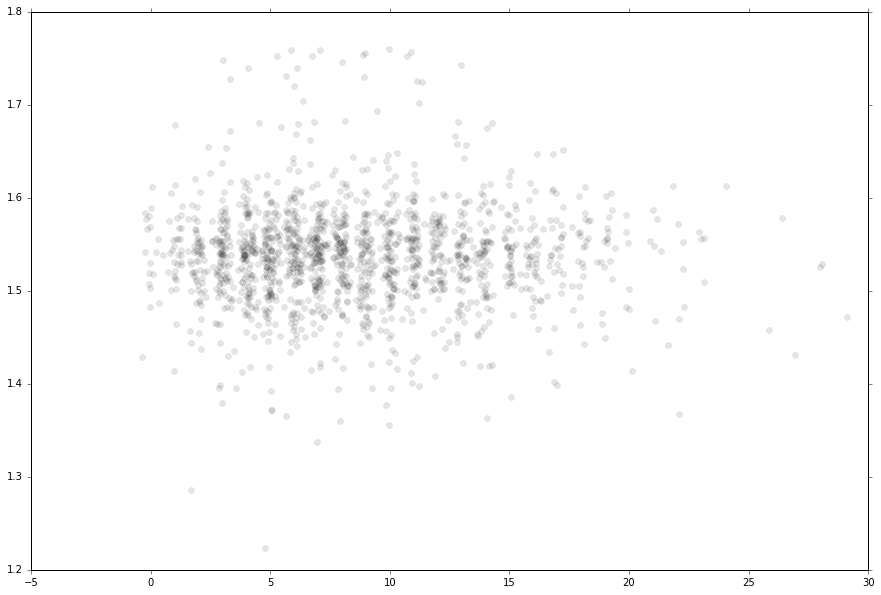

In [303]:
plt.figure(figsize=(15,10))
plt.plot(Yt+0.2*np.random.randn(np.size(Yt)), Yt_hat,'ko', alpha=0.1)

(25088, 4096)


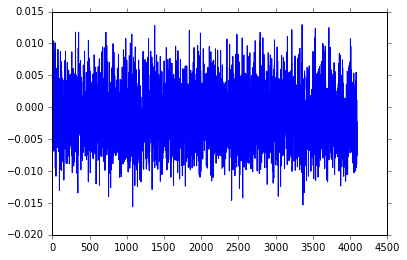

In [304]:
#plt.plot(model.get_weights()[-2])
print np.shape(model.get_weights()[-6])
plt.plot(model.get_weights()[-4][3])

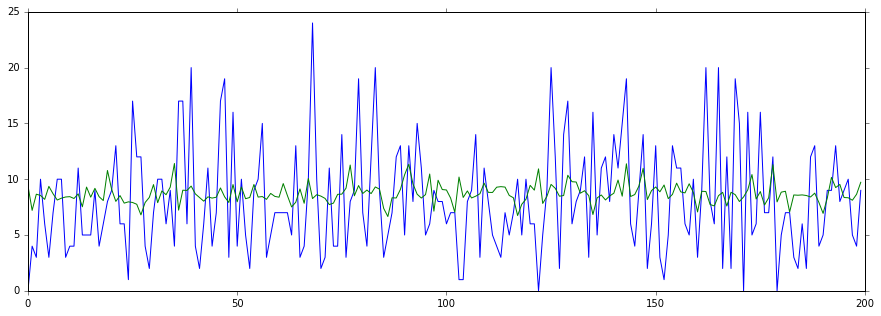

In [285]:
plt.figure(figsize=(15,5))
plt.plot(Yt[0:200])
plt.plot(Yt_hat[0:200])

## Show artificial stimuli to modeled neuron

### Prepare artificial hue stimuli

In [161]:
stimulipath = '../V4pydata'
impath = stimulipath+'/'+'stimuli/M3/Hues'
huefile = os.listdir(impath)
huefile.sort()

Xart = list()
for f in huefile:
    im = cv2.resize(cv2.imread(impath+'/'+f), (224, 224)).astype(np.float32)
    im[:,:,0] -= 103.939
    im[:,:,1] -= 116.779
    im[:,:,2] -= 123.68
    im = im.transpose((2,0,1))
    Xart.append(im)
Xart = np.array(Xart)

### Predict responses to artificial hue stimuli

In [281]:
Yart_hat = model.predict(Xart)

### Visualize

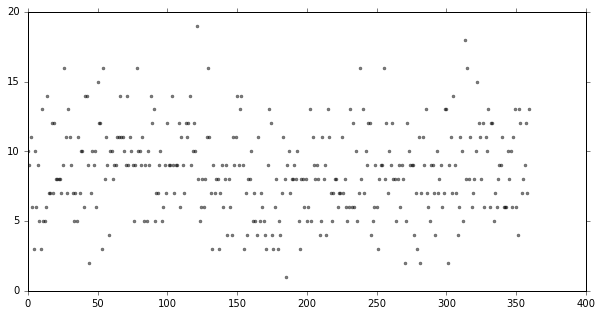

In [284]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(360), np.squeeze(np.random.poisson(Yart_hat)), 'k.', alpha=0.5)